<a href="https://colab.research.google.com/github/revaza05/geo-hate-speech-analysis/blob/main/notebooks/tfidf_logreg_classifier_with_lime_explanations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This notebook contains the code for training georgian hate speech classifier based on youtube and facebook comments data that is labeled manually.

# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from wordcloud import WordCloud
import sys
import sklearn

# Load Georgian Hate Speech Dataset

In [2]:
!wget https://raw.githubusercontent.com/revaza05/geo-hate-speech-analysis/main/combined-data/combined-labeled-data.csv

--2023-11-08 18:57:36--  https://raw.githubusercontent.com/revaza05/geo-hate-speech-analysis/main/combined-data/combined-labeled-data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 285785 (279K) [text/plain]
Saving to: ‘combined-labeled-data.csv’

combined-labeled-da 100%[===================>] 279.09K  --.-KB/s    in 0.02s   

2023-11-08 18:57:36 (12.1 MB/s) - ‘combined-labeled-data.csv’ saved [285785/285785]



In [3]:
raw_data = pd.read_csv("combined-labeled-data.csv")

In [4]:
raw_data.head()

,hate,female,filtered_text
0,1.0,0.0,ჩაიგდე ხმა შე მავნებელი ომი საქართველომ დაიწყო...
1,1.0,1.0,სამარცხვინო ქალო მიდი გაეკიდე ქაცარავას
2,0.0,0.0,იმოწმედეთ პრეზიდენტო
3,1.0,1.0,რა უზნეო ქალი ხარ არ იცი როგორ აურიო ქვეყანა გ...
4,1.0,0.0,Neta icodet mainc ras bjuturobt


# Preprocess Data

### Explore Raw Data

Explore samples with missing labels

In [5]:
print(f"{round(raw_data.hate.isna().sum()/raw_data.shape[0] * 100.0, 2)}% missing labels")

0.0% missing labels


We only have Hate speech labels. The rest is assumed to be non-hate speech labels so we relabel data here

In [6]:
raw_data.hate.dropna().value_counts()

0.0    1449
1.0     674
Name: hate, dtype: int64

In [7]:
raw_data.hate.fillna(0).value_counts(normalize=True)

0.0    0.682525
1.0    0.317475
Name: hate, dtype: float64

explore empty texts

In [8]:
(raw_data['filtered_text'].apply(lambda x: len(x) if isinstance(x, str) else 0) == 0).sum()

0

In [9]:
raw_data['female'].value_counts()

0.0    1958
1.0     163
Name: female, dtype: int64

### Extract Dataset From Raw Data

In [10]:
dataset = raw_data[['hate', 'filtered_text']]

In [11]:
dataset.head()

,hate,filtered_text
0,1.0,ჩაიგდე ხმა შე მავნებელი ომი საქართველომ დაიწყო...
1,1.0,სამარცხვინო ქალო მიდი გაეკიდე ქაცარავას
2,0.0,იმოწმედეთ პრეზიდენტო
3,1.0,რა უზნეო ქალი ხარ არ იცი როგორ აურიო ქვეყანა გ...
4,1.0,Neta icodet mainc ras bjuturobt


In [12]:
dataset.columns = ['label', 'text']

In [13]:
dataset = dataset[dataset['text'].apply(lambda x: len(x) if isinstance(x, str) else 0) > 0]

In [14]:
dataset.label.fillna(0, inplace=True)

In [15]:
dataset.label.value_counts(normalize=True)

0.0    0.682525
1.0    0.317475
Name: label, dtype: float64

Perform transliteration of georgian texts written with english letters

In [16]:
def transliterate_to_georgian(text):
    transliteration_dict = {
        'a': 'ა',
        'b': 'ბ',
        'g': 'გ',
        'd': 'დ',
        'e': 'ე',
        'v': 'ვ',
        'z': 'ზ',
        't': 'თ',
        'i': 'ი',
        'k': 'კ',
        'l': 'ლ',
        'm': 'მ',
        'n': 'ნ',
        'o': 'ო',
        'p': 'პ',
        'zh': 'ჟ',
        'r': 'რ',
        's': 'ს',
        'T': 'ტ',
        'u': 'უ',
        'f': 'ფ',
        'q': 'ქ',
        'gh': 'ღ',
        'y': 'ყ',
        'sh': 'შ',
        'ch': 'ჩ',
        'ts': 'ც',
        'c': 'ც',
        'dz': 'ძ',
        'ts': 'წ',
        'w': 'წ',
        'ch': 'ჭ',
        'kh': 'ხ',
        'x': 'ხ',
        'j': 'ჯ',
        'h': 'ჰ',
    }

    georgian_text = ''
    if text is not None and isinstance(text, str):
        for char in text.lower():
            if char in transliteration_dict:
                georgian_text += transliteration_dict[char]
            else:
                georgian_text += char

    return georgian_text

In [17]:
dataset['text'] = dataset['text'].apply(transliterate_to_georgian)

In [18]:
dataset.loc[2057, 'text']

'მადლობა კრისტი რო ესეთ ვიდეოებს იღებ ჩემი შვილი რო მეტყვის მამა ყლე რა არისო ამას ვაჩვანებ'

In [19]:
dataset.sample(20)

,label,text
405,0.0,წარმატებები
448,0.0,არმატებები
591,0.0,მაგარი ხარ ირაკლი მოაჯინე ერთ ადგილზე მთავარია...
642,0.0,საგოლ
1255,0.0,წარმატებები
557,0.0,წარმატებები
406,0.0,ვამაყობ ასეთი ძლიერი და სწორი გზით მიმავალი პრ...
1504,0.0,წარმატებები და ბედნიერება
1326,0.0,და ვირუსზე რომ ალაპარაკდნენ ეს რას მივაწეროთ ე...
982,0.0,წარმატებები პრემიერო


# Train Classifier

In [20]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=79b423c6104dffbd28f7b4161fc7a8b11120f7b8f6407ba03f57a7701ad4a382
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from lime.lime_text import LimeTextExplainer
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import StratifiedKFold

In [59]:
# Define the TF-IDF vectorizer with a vocabulary size of 10,000 and n-grams of 1-3
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(2, 10), analyzer="char_wb")

# Define the PCA dimensionality reduction with a suitable number of components
svd = TruncatedSVD(n_components=100)  # Adjust the number of components as needed

# Define the logistic regression classifier
logistic_regression = LogisticRegression()

# Create the pipeline with TF-IDF, PCA, and Logistic Regression
pipeline = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('svd', svd),
    ('classifier', logistic_regression)
])

# Assuming you have your data in X and labels in y
X = dataset['text']
y = dataset['label']

# Split the data into an 80/20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Perform 3-fold cross-validation with F1 score evaluation metrics
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
f1_scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='f1')

# Print the F1 scores for each fold
for fold, f1 in enumerate(f1_scores):
    print(f'Fold {fold + 1} F1 Score: {f1}')

# Train the classifier on the entire training set and evaluate on the test set
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
f1_test = f1_score(y_test, y_pred)

print(f'Test F1 Score: {f1_test}')

Fold 1 F1 Score: 0.8963730569948186
Fold 2 F1 Score: 0.901098901098901
Fold 3 F1 Score: 0.9405405405405405
Test F1 Score: 0.9090909090909091


Show vocab samples:

In [60]:
list(pipeline.steps[0][1].vocabulary_.keys())[:30]

[' წ',
 'წა',
 'არ',
 'რმ',
 'მა',
 'ატ',
 'ტე',
 'ებ',
 'ბე',
 'ბი',
 'ი ',
 ' წა',
 'წარ',
 'არმ',
 'რმა',
 'მატ',
 'ატე',
 'ტებ',
 'ებე',
 'ბებ',
 'ები',
 'ბი ',
 ' წარ',
 'წარმ',
 'არმა',
 'რმატ',
 'მატე',
 'ატებ',
 'ტებე',
 'ებებ']

# LIME explanations

In [61]:
def get_influential_words(comment, pipeline, num_features=10):
    # Create a LIME explainer
    explainer = LimeTextExplainer(
        kernel_width=25,
        kernel=None,
        verbose=True,
        class_names=['non-hate', 'hate'],
        feature_selection='auto',
        split_expression='\W+',
        bow=True,
        mask_string=None,
        random_state=42,
        char_level=False
    )

    # Define a function to predict using your classifier
    predict_fn = lambda x: pipeline.predict_proba(x)

    # Explain the prediction for the given comment
    explanation = explainer.explain_instance(comment, predict_fn, num_features=num_features)

    # Get influential words and their importance scores
    influential_words = explanation.as_list()

    return influential_words

In [62]:
def generate_visual_explanation(comment, pipeline, num_features=10):

    # get influential words using Lime Explainer
    influential_words = get_influential_words(comment, pipeline, num_features)

    # Create a heatmap-like visualization
    weights = [x[1] for x in influential_words]
    words = [x[0] for x in influential_words]
    colors = plt.cm.RdBu(np.array(weights) / max(weights))  # Normalize weights for color mapping

    plt.figure(figsize=(12, 6))
    plt.barh(words, weights, color=colors)
    plt.xlabel('Word Importance')
    plt.title('Influential Words in Comment')
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.show()

In [63]:
hate_sample = dataset.loc[2057, 'text']
hate_sample

'მადლობა კრისტი რო ესეთ ვიდეოებს იღებ ჩემი შვილი რო მეტყვის მამა ყლე რა არისო ამას ვაჩვანებ'

In [64]:
non_hate_sample = dataset.loc[980, 'text']
non_hate_sample

'როგორ დერსკად ელაპარაჯება საგორ'

In [65]:
get_influential_words(hate_sample, pipeline, 10)

Intercept 0.5317434484331052
Prediction_local [0.74449526]
Right: 0.7366924910971475


[('ყლე', 0.14643017677233233),
 ('მადლობა', -0.13287108292451905),
 ('კრისტი', 0.10500850039446874),
 ('შვილი', 0.036659819969813184),
 ('ვიდეოებს', 0.030963923131649515),
 ('ჩემი', -0.03050864416414091),
 ('მეტყვის', 0.030434372231688458),
 ('არისო', 0.025942293816744445),
 ('ამას', 0.01927900732137561),
 ('იღებ', -0.018586551675820958)]

In [66]:
get_influential_words(non_hate_sample, pipeline, 10)

Intercept 0.3780162785470484
Prediction_local [0.37248624]
Right: 0.37168652876408387


[('საგორ', -0.048099068903679126),
 ('ელაპარაჯება', 0.04450093375071189),
 ('როგორ', -0.02928382690601239),
 ('დერსკად', 0.027351919166571127)]

Intercept 0.5278721811193895
Prediction_local [0.74622435]
Right: 0.7366924910971475


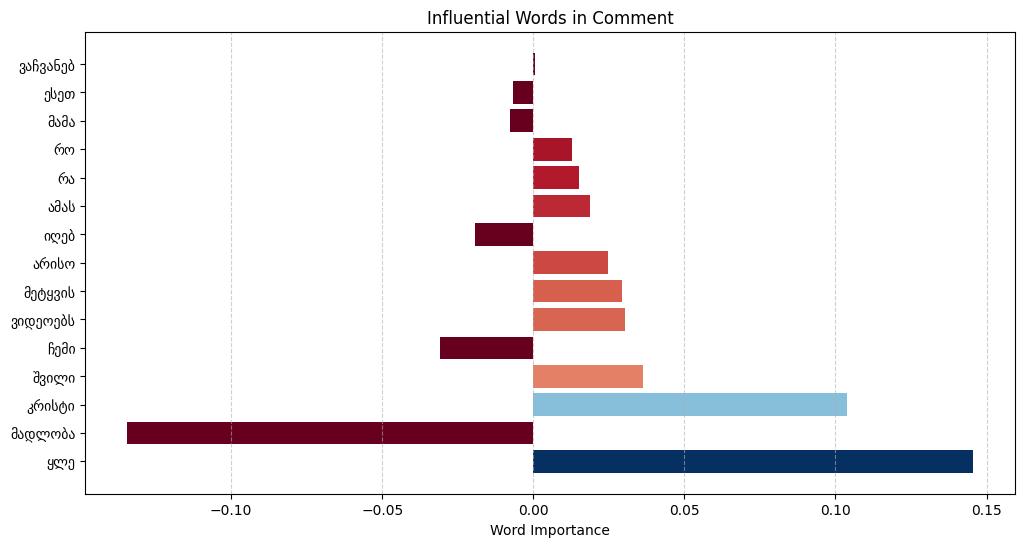

In [67]:
generate_visual_explanation(hate_sample, pipeline, 20)

Intercept 0.3780162785470484
Prediction_local [0.37248624]
Right: 0.37168652876408387


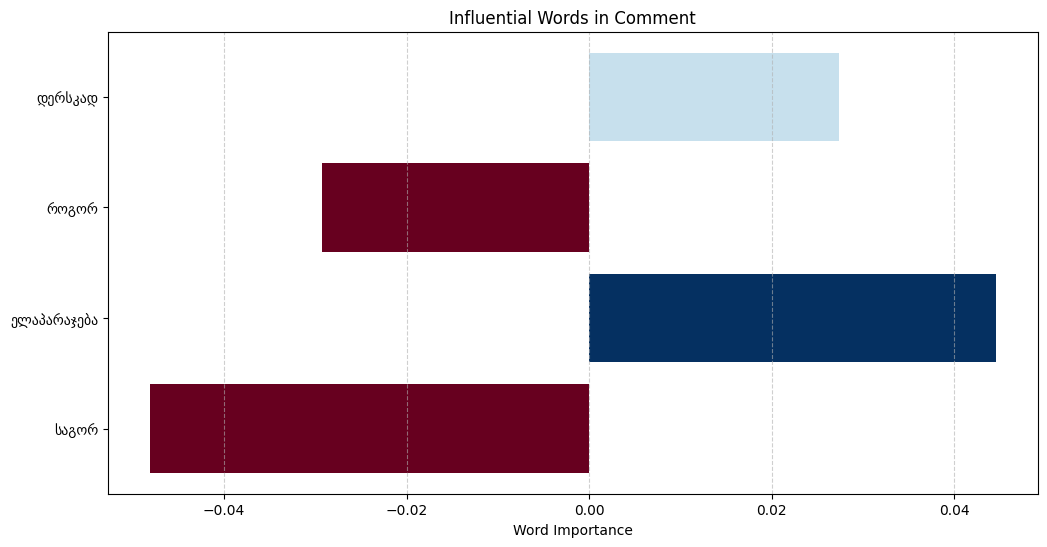

In [68]:
generate_visual_explanation(non_hate_sample, pipeline, 20)

# See Test Set Inference Results

In [69]:
test_inference_results_df = pd.DataFrame(
    {
        "text": X_test.values,
        "label": y_test.values,
        "predicted_label": pipeline.predict(X_test),
        "hate_prob": pipeline.predict_proba(X_test)[:, 1],
        "non_hate_prob": pipeline.predict_proba(X_test)[:, 0]
    }
)

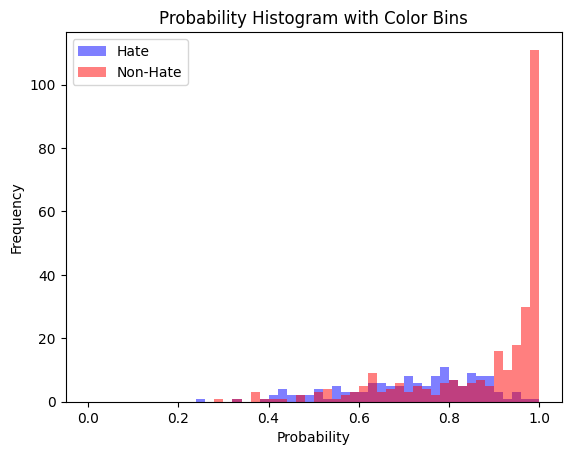

In [76]:
# Create a figure and axis
fig, ax = plt.subplots()

# Set the number of bins and range for the histogram
n_bins = 50
bin_range = (0, 1)

# Plot histograms for positive and negative class probabilities with different colors
ax.hist(
    test_inference_results_df['hate_prob'][test_inference_results_df.label == 1],
    bins=n_bins, range=bin_range, color='b', alpha=0.5, label='Hate')
ax.hist(
    test_inference_results_df['non_hate_prob'][test_inference_results_df.label == 0],
    bins=n_bins, range=bin_range, color='r', alpha=0.5, label='Non-Hate')

# Customize the plot
ax.set_xlabel('Probability')
ax.set_ylabel('Frequency')
ax.set_title('Probability Histogram with Color Bins')
ax.legend()

# Show the histogram
plt.show()

In [70]:
test_inference_results_df.apply(lambda x: x['label'] == x['predicted_label'], axis=1).value_counts(normalize=True)

True     0.941176
False    0.058824
dtype: float64

In [77]:
test_inference_results_df.head(10)

,text,label,predicted_label,hate_prob,non_hate_prob
0,ცარმათებები ბ ირაკლი,0.0,0.0,0.019132,0.980868
1,ხო იდზახის სჰემხვდი და იქ მომთხოვე ახსნაო ვითო...,1.0,1.0,0.964083,0.035917
2,წარმატებები ბატონო პრემიერო,0.0,0.0,0.002354,0.997646
3,წარმატებები უჭკვიანეს და სამშობლოს მოყვარულ პრ...,0.0,0.0,0.068242,0.931758
4,ცარმათება ცჰვენს კვეყანას,0.0,0.0,0.221125,0.778875
5,წარმატებები,0.0,0.0,0.004365,0.995635
6,წარმატებები,0.0,0.0,0.004365,0.995635
7,ქრისთი სჰე ყლეო ყლიფონა ბოზანდარა ბიცჰი ხარ და...,1.0,1.0,0.898521,0.101479
8,კარგი ხარ ირაკლი,0.0,0.0,0.104780,0.895220
9,საამაყო პრემიერი,0.0,0.0,0.037149,0.962851


## Random Hate Speech Examples In Test Data

Intercept 0.8393963562078975
Prediction_local [0.98022345]
Right: 0.9640825717076672


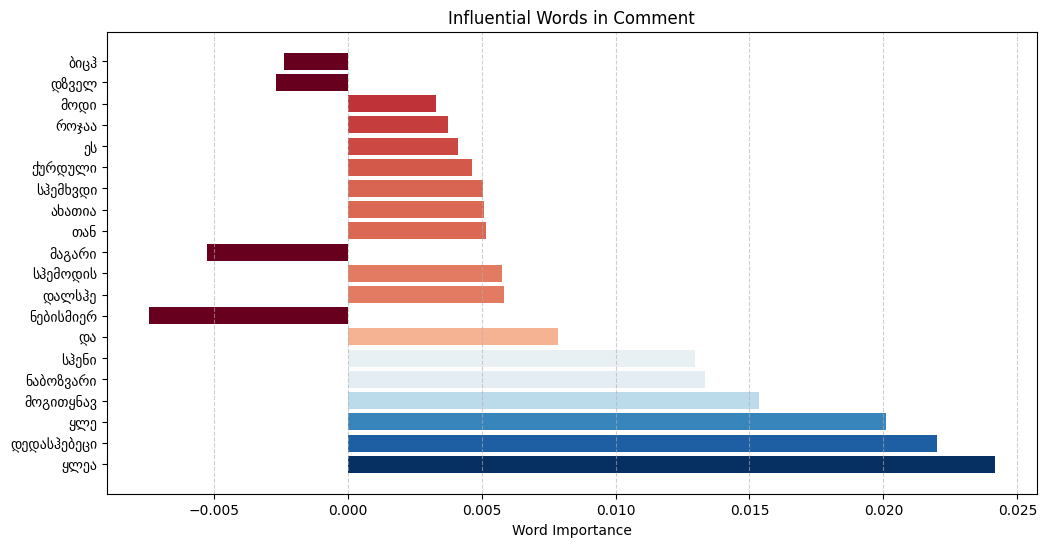

('ხო იდზახის სჰემხვდი და იქ მომთხოვე ახსნაო ვითომ ხო დზველ ბიცჰობს არადა მაგარი ნაბოზვარი როჯაა ჯერ რა ყლეა თიპს ზვეზდოცჰკა ნაკოლკა და ქურდული ნისჰნები ახათია თიპი იმ დონის ყლეა რო ლაივსჰი სჰემოდის თან თითველი ეს ყლე და დალსჰე რას იდზახის რა ოფ ქოურს რა ბიცჰ მოდი ნებისმიერ დროს სჰეგხვდები და მოგითყნავ მაგ ნაკოლკებს ვითოთ დზველი ბიცჰი დედასჰებეცი სჰენი',
 None)

In [75]:
test_inference_results_df.iloc[1]['text'], generate_visual_explanation(test_inference_results_df.iloc[1]['text'], pipeline, 20)

Intercept 0.6686631023278611
Prediction_local [0.9202975]
Right: 0.898520675910737


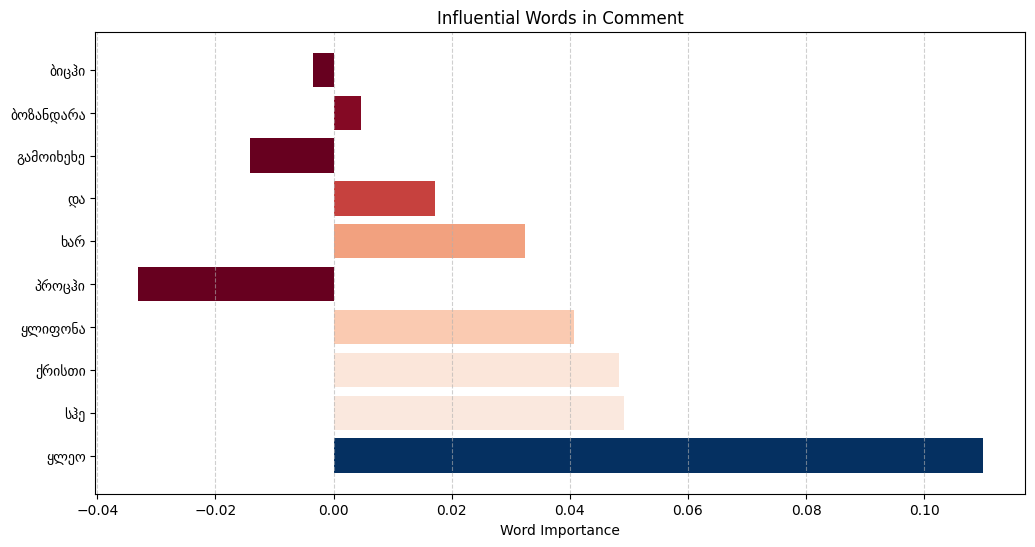

('ქრისთი სჰე ყლეო ყლიფონა ბოზანდარა ბიცჰი ხარ და გამოიხეხე პროცჰი', None)

In [79]:
test_inference_results_df.iloc[7]['text'], generate_visual_explanation(test_inference_results_df.iloc[7]['text'], pipeline, 20)

Intercept 0.30597109641277165
Prediction_local [0.04830018]
Right: 0.0682417524697741


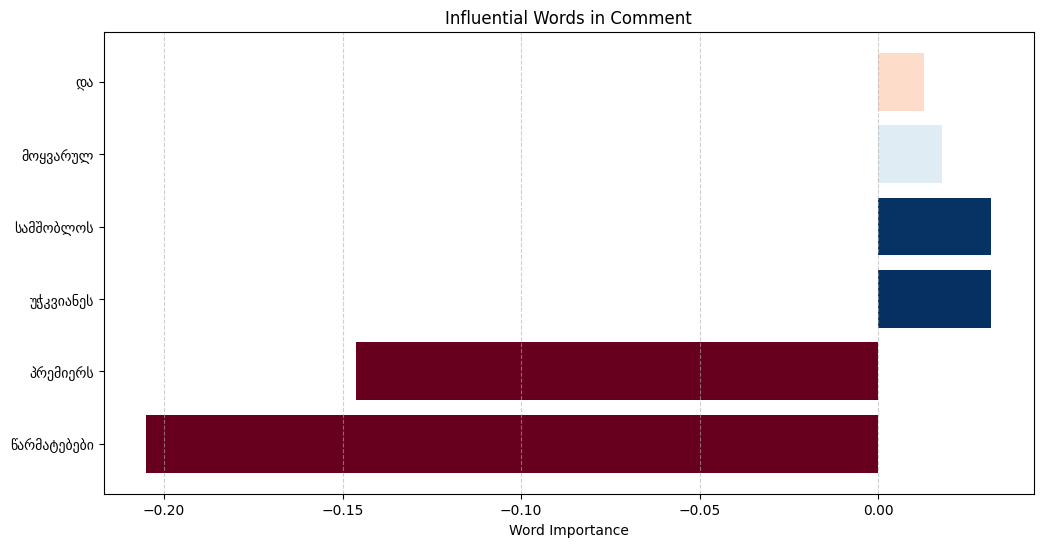

('წარმატებები უჭკვიანეს და სამშობლოს მოყვარულ პრემიერს', None)

In [83]:
test_inference_results_df.iloc[3]['text'], generate_visual_explanation(test_inference_results_df.iloc[3]['text'], pipeline, 20)

## Comments About President

In [88]:
test_inference_results_df[test_inference_results_df.text.apply(lambda x: 'პრეზი' in x)]

,text,label,predicted_label,hate_prob,non_hate_prob
65,ეს არაქალი მარტო პრეზიდენტობიდან კიარა ქვეყნიდ...,1.0,1.0,0.708803,0.291197
141,ყოჩაღ ჩვენს პრეზიდენტს სწორად შეაფასა და დააფა...,0.0,0.0,0.335870,0.664130
159,საამაყო პრემიერი ფუფალა პრეზიდენტი კი გადადგეს,0.0,0.0,0.187339,0.812661
244,წარმატებები ქალბატონო პრეზიდენტო,0.0,0.0,0.159872,0.840128
343,მანანა კობახიძემ ნაძირალა ხეპრე ირაკლი კობახიძ...,1.0,1.0,0.610748,0.389252
416,ეს ქვეყანა თუ არ მოგწონს რომ აღარაფერი გიკვირს...,1.0,1.0,0.797775,0.202225


Intercept 0.5173735031663871
Prediction_local [0.72149469]
Right: 0.7088031588869361


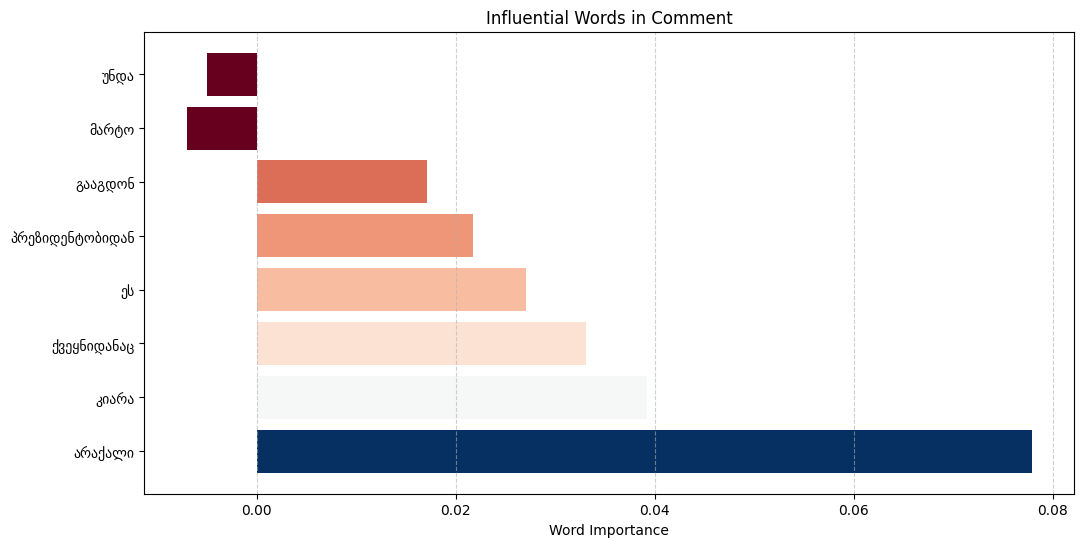

('ეს არაქალი მარტო პრეზიდენტობიდან კიარა ქვეყნიდანაც უნდა გააგდონ', None)

In [89]:
test_inference_results_df.iloc[65]['text'], generate_visual_explanation(test_inference_results_df.iloc[65]['text'], pipeline, 20)

Intercept 0.389502349930152
Prediction_local [0.33102474]
Right: 0.33586985252627816


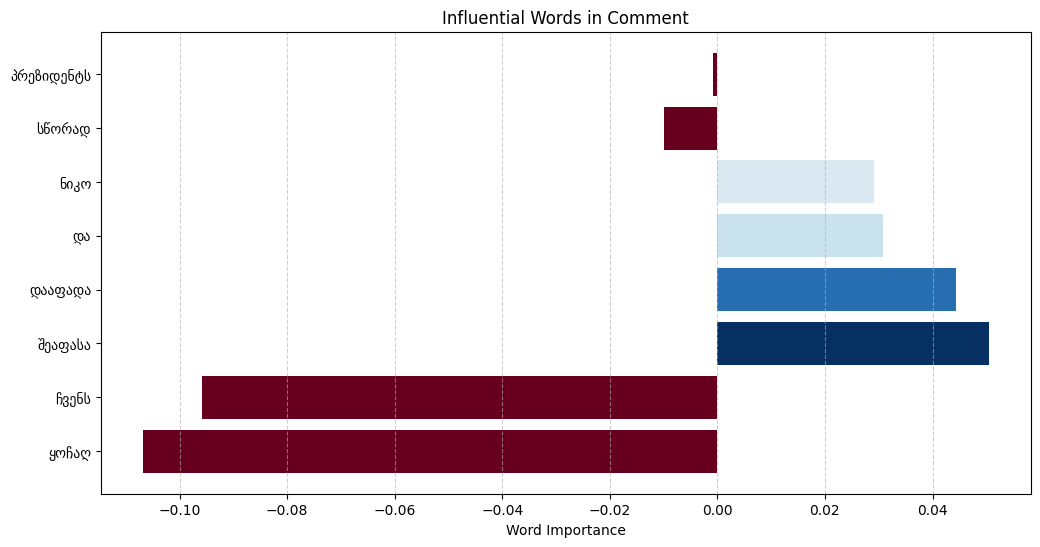

('ყოჩაღ ჩვენს პრეზიდენტს სწორად შეაფასა და დააფადა ნიკო', None)

In [90]:
test_inference_results_df.iloc[141]['text'], generate_visual_explanation(test_inference_results_df.iloc[141]['text'], pipeline, 20)

Intercept 0.3749031661626794
Prediction_local [0.17912749]
Right: 0.1873388832436018


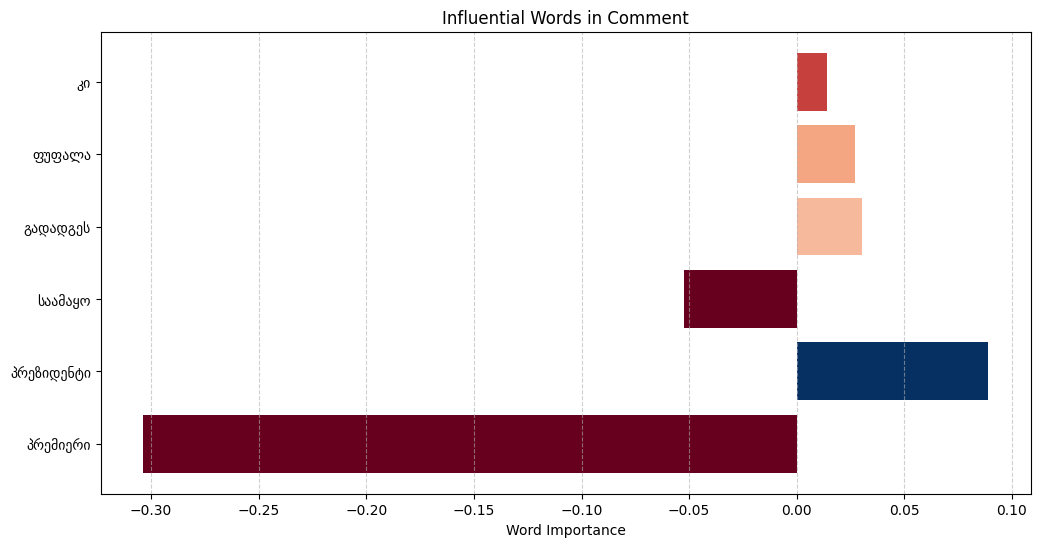

('საამაყო პრემიერი ფუფალა პრეზიდენტი კი გადადგეს', None)

In [91]:
test_inference_results_df.iloc[159]['text'], generate_visual_explanation(test_inference_results_df.iloc[159]['text'], pipeline, 20)

Intercept 0.37166386416078095
Prediction_local [0.13660281]
Right: 0.15987189469705435


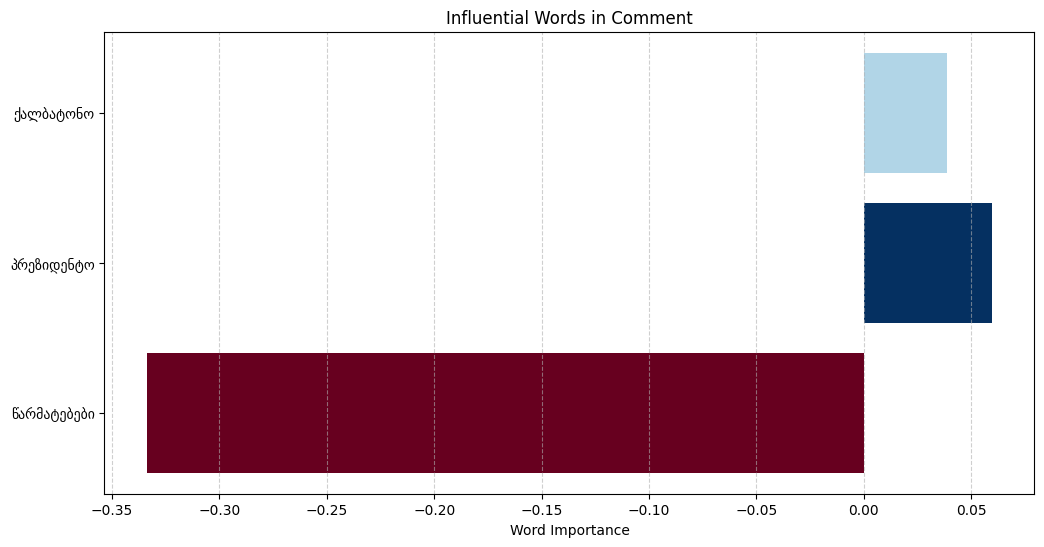

('წარმატებები ქალბატონო პრეზიდენტო', None)

In [92]:
test_inference_results_df.iloc[244]['text'], generate_visual_explanation(test_inference_results_df.iloc[244]['text'], pipeline, 20)

Intercept 0.49584907971804265
Prediction_local [0.61258398]
Right: 0.610748141279548


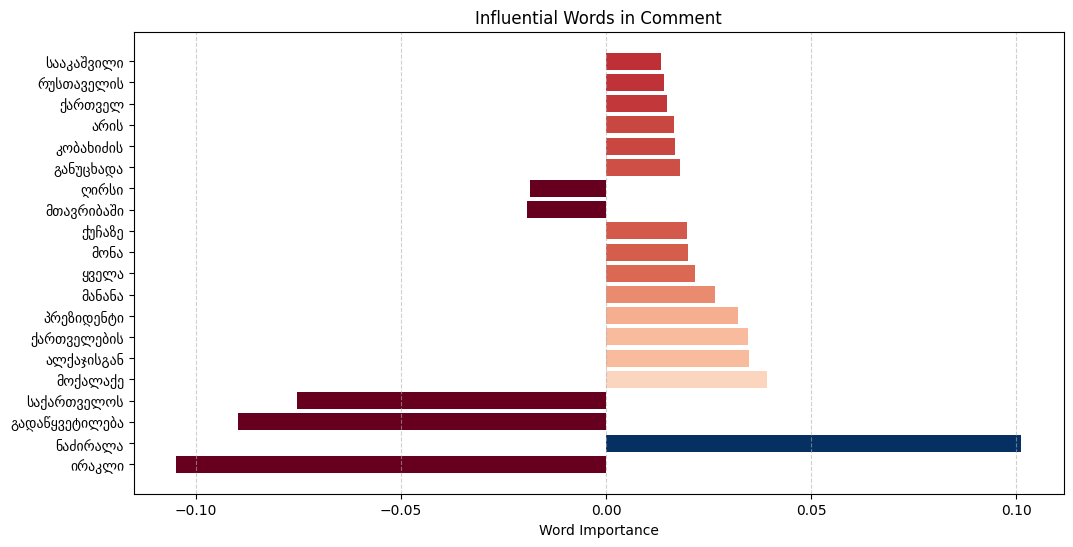

('მანანა კობახიძემ ნაძირალა ხეპრე ირაკლი კობახიძის წიოწკამ განუცხადა ქართველ ემიგრანტებს წელს რომ ექს პრეზიდენტი სააკაშვილი არ არის ღირსი ყოფილიყი საქართველოს მოქალაქე მაგ მონა ალქაჯისგან ელოდით რომ კეთილ სინდისიერი გადაწყვეტილება მიიღებოდა ყველა ქოცი მთავრიბაში რუსთაველის ქუჩაზე უნდა გატუსაღდეს ქართველების გაუბედურებისთვის',
 None)

In [93]:
test_inference_results_df.iloc[343]['text'], generate_visual_explanation(test_inference_results_df.iloc[343]['text'], pipeline, 20)

Intercept 0.5951478456093273
Prediction_local [0.81052217]
Right: 0.7977754356902539


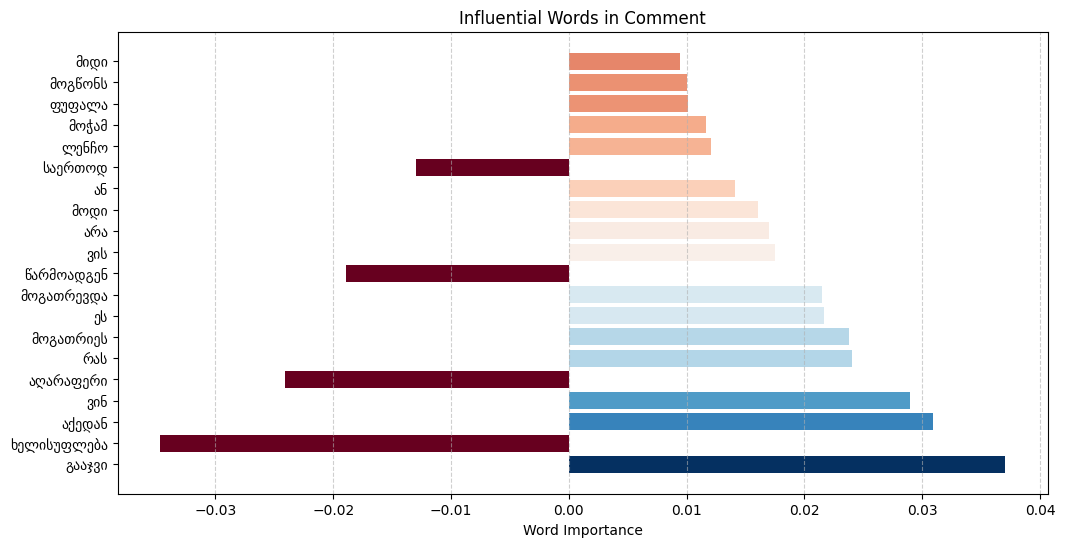

('ეს ქვეყანა თუ არ მოგწონს რომ აღარაფერი გიკვირს გააჯვი აქედან ძალით მოგათრიეს აქ ეს ხელისუფლება რომ არა ვინ მოგათრევდა პრეზიდენტად გინდ მიდი გინდ მოდი რას წარმოადგენ საერთოდ ან ვის რას მოჭამ ლენჩო ფუფალა',
 None)

In [94]:
test_inference_results_df.iloc[416]['text'], generate_visual_explanation(test_inference_results_df.iloc[416]['text'], pipeline, 20)

## Comments About Premier Minister

In [96]:
_premier_samples = test_inference_results_df[test_inference_results_df.text.apply(lambda x: 'პრემიერ' in x)]

In [98]:
_premier_samples.label.value_counts()

0.0    77
1.0     1
Name: label, dtype: int64

In [99]:
_premier_samples

,text,label,predicted_label,hate_prob,non_hate_prob
2,წარმატებები ბატონო პრემიერო,0.0,0.0,0.002354,0.997646
3,წარმატებები უჭკვიანეს და სამშობლოს მოყვარულ პრ...,0.0,0.0,0.068242,0.931758
9,საამაყო პრემიერი,0.0,0.0,0.037149,0.962851
11,წარმატებები ჩვენს საამაყო პრემიერს საუკეთესო გ...,0.0,0.0,0.019803,0.980197
21,წარმატებებიბატონო პრემიერო,0.0,0.0,0.003007,0.996993
...,...,...,...,...,...
397,ბრავო პრემიერო,0.0,0.0,0.011661,0.988339
405,წარმატებები ჩვენს პრემიერს თავისი გუნდით უფალმ...,0.0,0.0,0.050468,0.949532
408,ჩვენო პრემიერ მინისტრო ბევრ ქვეყნებს და შინაურ...,1.0,0.0,0.326406,0.673594
418,წარმატებები ღირსეულო პრემიერო ჩვენი ქვეყნის წი...,0.0,0.0,0.020507,0.979493


Intercept 0.379135455928561
Prediction_local [0.32321584]
Right: 0.3264064530528939


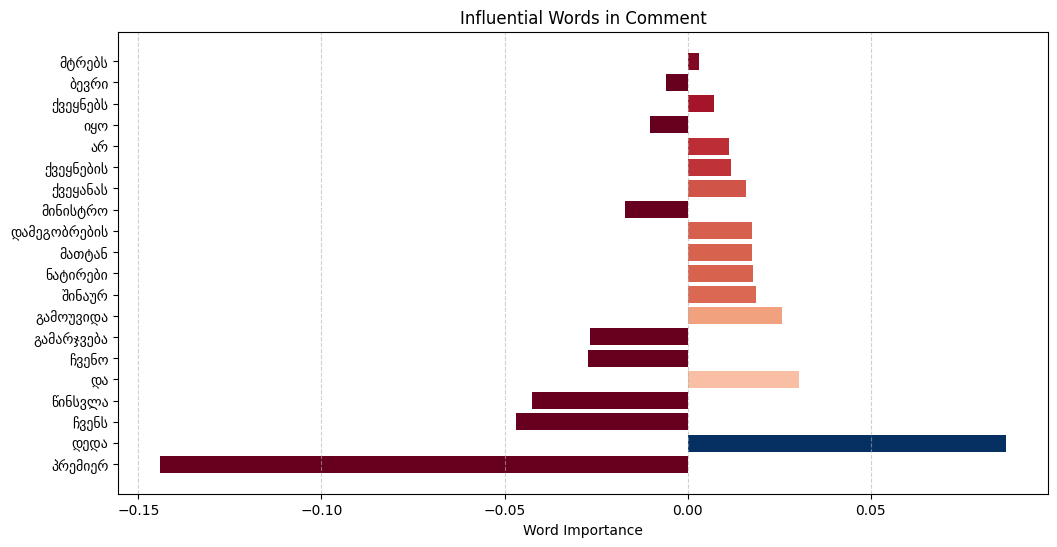

('ჩვენო პრემიერ მინისტრო ბევრ ქვეყნებს და შინაურ მტრებს დედა აქვთ ნატირები ბევრი ქვეყნების ოცნება იყო მათტან დამეგობრების მაგრამ არ გამოუვიდა წინსვლა და გამარჯვება ჩვენს ქვეყანას',
 None)

In [100]:
test_inference_results_df.iloc[408]['text'], generate_visual_explanation(test_inference_results_df.iloc[408]['text'], pipeline, 20)

Intercept 0.20805111053195668
Prediction_local [0.03599667]
Right: 0.05046764367311796


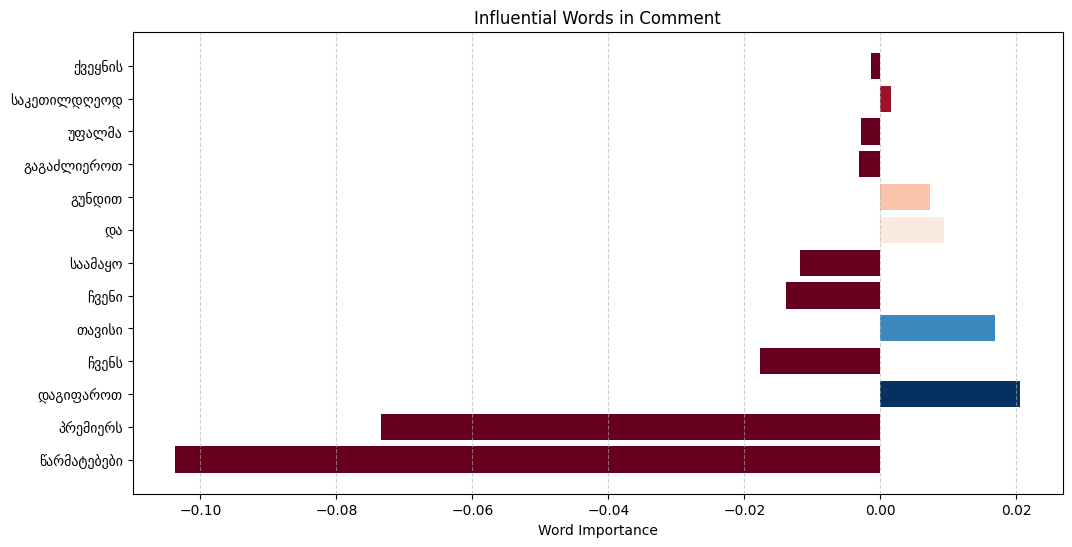

('წარმატებები ჩვენს პრემიერს თავისი გუნდით უფალმა გაგაძლიეროთ და დაგიფაროთ ჩვენი საამაყო ქვეყნის საკეთილდღეოდ',
 None)

In [101]:
test_inference_results_df.iloc[405]['text'], generate_visual_explanation(test_inference_results_df.iloc[405]['text'], pipeline, 20)

# Store Trained Model For Inference

In [102]:
!pip install joblib

In [103]:
import joblib

In [104]:
joblib.dump(pipeline, 'tfidf_logreg_classifier.pkl')

['tfidf_logreg_classifier.pkl']